In [1]:
import tensorflow as tf
import os

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# pip install opencv-python

In [4]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

C:\Users\masan\AppData\Local\Temp\ipykernel_18340\2123835270.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
img = cv2.imread(os.path.join('data', 'FAKE', '1001 (2).jpg'))

In [6]:
img.shape

(32, 32, 3)

### Loading the data

In [7]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(32, 32))

Found 99996 files belonging to 2 classes.


In [8]:
data_it = data.as_numpy_iterator()

In [9]:
batch = data_it.next()

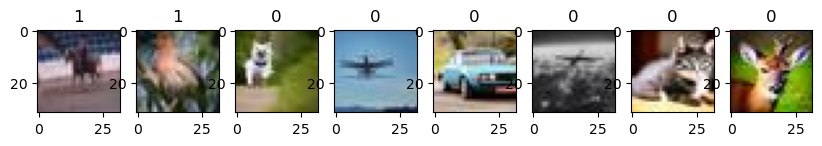

In [10]:
fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing

In [11]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


Scaling the data between 0 and 1

In [12]:
data = data.map(lambda x, y : (x/255, y))

In [13]:
scaled_it = data.as_numpy_iterator()

In [14]:
batch = scaled_it.next()

In [15]:
print(batch[0].min())
print(batch[0].max())

0.0
1.0


Splitting the data into training, cross-validation and testing sets

In [16]:
len(data)

3125

In [17]:
train_size = int(len(data)*0.7)
cv_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [18]:
train_size+cv_size+test_size

3125

In [19]:
train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size+cv_size).take(test_size)

In [20]:
# train

In [21]:
len(train)+len(cv)+len(test)

3125

### Building the DL Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

In [23]:
# model = Sequential()

In [24]:
# model.add(Conv2D(16, (4, 4), 1, activation='relu', input_shape=(32, 32, 3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (4, 4), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (4, 4), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


In [25]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

model = Sequential() 
model.add(base_model)
model.add(Flatten())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))




94765736/94765736 [==============================] - 96s 1us/step


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [27]:
def augmant_data(x,y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)

    return x,y

train_augmanted_data = data.map(augmant_data)

In [28]:
logdir = 'logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam

initial_learning_rate = 0.001

def lr_scheduler(epochs, lr):
    return lr*0.95

lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)
early_stoping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
model.compile(optimizer=optimizer, loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
hist = model.fit(train_augmanted_data, epochs=20, validation_data=cv, callbacks=[tensorboard_callback, lr_schedule, early_stoping])

Epoch 1/20


1352/3125 [===========>..................] - ETA: 12:00 - loss: 0.3715 - accuracy: 0.8433

### Performance

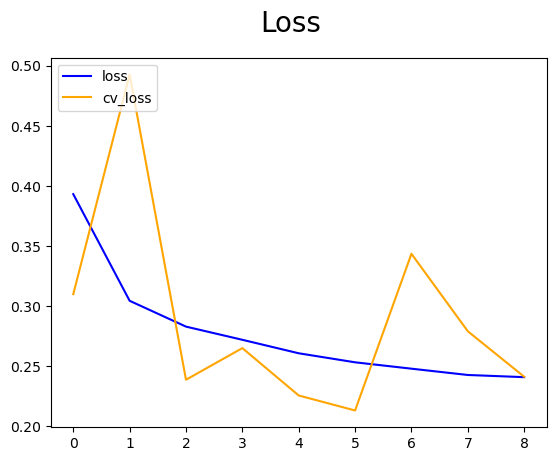

In [40]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='cv_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

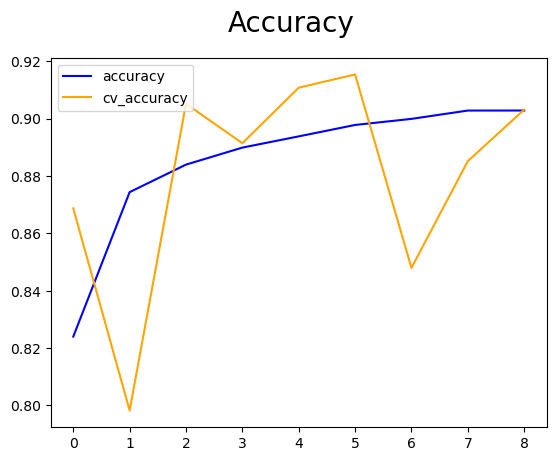

In [41]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='cv_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [43]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [44]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 126ms/step


In [45]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9238909482955933, Recall: 0.9049232602119446, Accuracy: 0.9150019884109497


In [46]:
from tensorflow.keras.models import load_model

In [47]:
model.save(os.path.join('model','ai_imageclassifier'), save_format='tf')

INFO:tensorflow:Assets written to: model\ai_imageclassifier\assets


INFO:tensorflow:Assets written to: model\ai_imageclassifier\assets


In [48]:
model = load_model(os.path.join('model','ai_imageclassifier'))

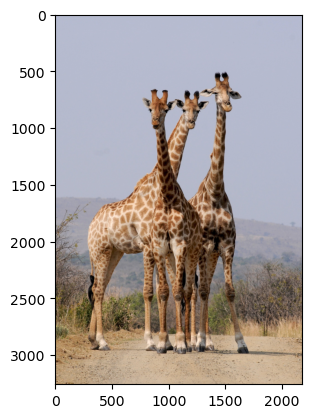

In [77]:
img = cv2.imread('test_2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [78]:
resize = tf.image.resize(img, (32, 32))

In [79]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 31ms/step


In [80]:
y_pred

array([[2.0967873e-05]], dtype=float32)

In [81]:
if y_pred > 0.5: 
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: AI


In [82]:
print(resize)

tf.Tensor(
[[[182.40625  187.40625  207.40625 ]
  [180.40625  187.40625  206.40625 ]
  [181.       186.       206.      ]
  ...
  [182.       187.       207.      ]
  [182.40625  187.40625  207.40625 ]
  [180.5625   184.5625   209.5625  ]]

 [[181.       188.       207.      ]
  [183.       188.       208.      ]
  [182.       187.       209.      ]
  ...
  [182.       186.       211.      ]
  [184.375    187.3125   210.      ]
  [182.       187.       209.      ]]

 [[183.       188.       208.      ]
  [183.       188.       210.      ]
  [182.       187.       207.      ]
  ...
  [183.       188.       210.      ]
  [182.       187.       207.      ]
  [181.       186.       206.      ]]

 ...

 [[157.92578  117.92578   81.92578 ]
  [164.62695  127.62695   85.62695 ]
  [210.1289   175.14844  143.06055 ]
  ...
  [175.38086  155.38086  131.38086 ]
  [189.34375  159.30078  134.63477 ]
  [ 69.302734  57.396484  41.365234]]

 [[186.2832   153.2832   111.8457  ]
  [178.50781  154.19531  1